<a href="https://colab.research.google.com/github/skywalker0803r/mxnet_course/blob/master/mxnet_ppo_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install mxnet
import numpy as np 
import mxnet as mx 
from mxnet import gluon, autograd, nd
import mxnet.ndarray as F
from mxnet.gluon import nn
from mxnet.gluon.loss import L2Loss
import gym
from mxnet import init
import matplotlib.pyplot as plt

# some function

In [0]:
def nd_entropy(probs):
  return -nd.sum(probs*nd.log(probs+1e-8),axis=1)

# memory

In [0]:
class Memory:
  def __init__(self):
    self.actions = []
    self.states = []
    self.logprobs = []
    self.rewards = []
    self.is_terminals = []
  def clear_memory(self):
    del self.actions[:]
    del self.states[:]
    del self.logprobs[:]
    del self.rewards[:]
    del self.is_terminals[:]

# model

In [0]:
class ActorCritic_Discrete(gluon.Block):
  def __init__(self,action_dim):
    super(ActorCritic_Discrete, self).__init__()
    self.action_dim = action_dim
    with self.name_scope():
      self.probs = nn.Sequential()
      self.probs.add(nn.Dense(128,activation='relu'))
      self.probs.add(nn.Dense(action_dim))
      
      self.value = nn.Sequential()
      self.value.add(nn.Dense(128,activation='relu'))
      self.value.add(nn.Dense(1))       
  
  def choose_action(self, state, memory):
    state = nd.array(state)
    probs = nd.softmax(self.probs(state))
    action, log_prob = nd.sample_multinomial(probs, get_prob = True)
    memory.states.append(list(nd.squeeze(state).asnumpy())) 
    memory.actions.append(action.asnumpy()[0])
    memory.logprobs.append(log_prob.asnumpy()[0])
    return action.asnumpy()[0]
  
  def evaluate(self, state, action):
    state = nd.array(state)
    action = nd.array(action)
    probs = nd.softmax(self.probs(state))
    action_logprobs = nd.pick(probs.log(),action,axis=1)
    state_value = self.value(state)
    return action_logprobs, nd.squeeze(state_value), nd_entropy(probs) 

# forward test

In [5]:
a = ActorCritic_Discrete(action_dim=2)
a.initialize()
m = Memory()
#=============
action = a.choose_action([[1,1,1,1]],m)
print('action:',action)
print('states:',m.states)
print('actions:',m.actions)
print('logprobs:',m.logprobs)

action: 1
states: [[1.0, 1.0, 1.0, 1.0]]
actions: [1]
logprobs: [-0.67801327]


In [6]:
a = ActorCritic_Discrete(action_dim=2)
a.initialize()
m = Memory()
#=============
probs_log_action,value,entropy = a.evaluate([[1,1,1,1],
                                             [1,1,1,1],
                                             [1,1,1,1]],[0,1,0])
print(probs_log_action,value,entropy)


[-0.6901691  -0.69613415 -0.6901691 ]
<NDArray 3 @cpu(0)> 
[-0.00307417 -0.00307417 -0.00307417]
<NDArray 3 @cpu(0)> 
[0.6931428 0.6931428 0.6931428]
<NDArray 3 @cpu(0)>


# ppo

In [0]:
class PPO_Discrete(object):
  def __init__(self, action_dim, lr, gamma):
    
    # initialize policy
    self.policy = ActorCritic_Discrete(action_dim)
    self.policy.probs.initialize(init=init.Xavier())
    self.policy.value.initialize(init=init.Xavier())
    
    # initialize old policy
    self.policy_old = ActorCritic_Discrete(action_dim)
    self.policy_old.probs.initialize(init=init.Xavier())
    self.policy_old.value.initialize(init=init.Xavier())

    # initialize forward 4 net
    random_x = nd.random_uniform(shape=(1,state_dim))
    _ = self.policy.probs(random_x)
    _ = self.policy.value(random_x)
    _ = self.policy_old.probs(random_x)
    _ = self.policy_old.value(random_x)
    
    # Copy policy params to old policy:
    self.policy.probs.save_parameters("temp_probs.params")
    self.policy.value.save_parameters("temp_value.params")
    self.policy_old.probs.load_parameters("temp_probs.params")
    self.policy_old.value.load_parameters("temp_value.params")
    print('initialize copy params to old policy')
    
    self.lr = lr
    self.gamma = gamma
    self.trainer = gluon.Trainer(self.policy.collect_params(),'adam',{'learning_rate':self.lr})

  def update(self, memory): 
    
    # Monte Carlo estimate of state rewards:
    rewards = []
    discounted_reward = 0
    for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
      if is_terminal:
        discounted_reward = 0
      discounted_reward = reward + (self.gamma * discounted_reward)
      rewards.insert(0, discounted_reward)
    
    # Normalizing the rewards:
    rewards = np.array(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
    
    # sample batch data from memory
    old_states = memory.states
    old_actions = memory.actions
    old_logprobs = memory.logprobs

    # to ndarray
    rewards = nd.array(rewards)
    old_logprobs = nd.array(old_logprobs)

    # Optimize policy for 4 epochs:
    for _ in range(4):
      with autograd.record():    
        logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
        ratios = nd.exp(logprobs - old_logprobs)
        advantages = rewards - state_values
        surr1 = ratios * advantages
        surr2 = nd.clip(ratios, 0.8, 1.2)*advantages
        loss = -nd.minimum(surr1,surr2) + 0.5*(advantages)**2 - 0.01*dist_entropy
        loss = nd.mean(loss)
      # loss backward and trainer step
      loss.backward()
      self.trainer.step(1)
    
    # Copy policy params to old policy:
    self.policy.probs.save_parameters("temp_probs.params")
    self.policy.value.save_parameters("temp_value.params")
    self.policy_old.probs.load_parameters("temp_probs.params")
    self.policy_old.value.load_parameters("temp_value.params")
    print('copy params to old policy')

# env and params

In [0]:
env_name = "CartPole-v0"
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
render = False
solved_reward = 200         
log_interval = 10     
update_timestep = 2000
lr = 0.001
gamma = 0.99

# main

In [9]:
memory = Memory()
ppo = PPO_Discrete(action_dim,lr=0.001,gamma=0.99)

initialize copy params to old policy


In [10]:
all_rewards = []
avg_rewards = []
time_step = 0    

# run 50000 episode
for i_episode in range(50000):
  # reset env and R(total_reward)
  state = env.reset()
  R = 0
  # game start 
  for t in range(1000):
    time_step +=1
    # transform state to nd_array
    state = nd.array(np.expand_dims(state, 0))
    # choose action
    action = ppo.policy_old.choose_action(state, memory)
    # do action on env
    state, reward, done, _ = env.step(action)
    
    # append to memory
    R += reward
    memory.rewards.append(reward)
    memory.is_terminals.append(done)
    
    # every update_timestep ppo learn
    if time_step % update_timestep == 0:
      ppo.update(memory)
      memory.clear_memory()
      time_step = 0
    
    # game over
    if done:
      break            
  
  # every episode record R
  all_rewards.append(R)
  avg_rewards.append(np.mean(all_rewards[-10:]))
  
  # if solved!
  if (all_rewards[-1] >= solved_reward)&(avg_rewards[-1] >= solved_reward*0.9):
    print("########## Solved! ##########")
    print(i_episode,all_rewards[-1],avg_rewards[-1])
    break
  
  # print infomation
  if i_episode % log_interval == 0:
    print(i_episode,avg_rewards[-1])

0 10.0
10 17.2
20 21.6
30 19.4
40 22.6
50 21.6
60 21.5
70 25.8
80 27.2
copy params to old policy
90 23.7
100 28.2
110 22.5
120 26.0
130 20.4
140 28.0
150 22.5
160 24.5
170 22.3
copy params to old policy
180 26.7
190 26.6
200 25.4
210 23.7
220 30.2
230 26.6
240 28.8
copy params to old policy
250 30.7
260 35.1
270 28.9
280 30.9
290 25.6
300 39.4
copy params to old policy
310 28.0
320 25.9
330 31.6
340 26.3
350 36.8
360 36.0
370 30.4
copy params to old policy
380 37.7
390 35.6
400 25.1
410 32.8
420 38.4
430 40.5
copy params to old policy
440 35.0
450 42.9
460 36.0
470 37.0
480 28.9
copy params to old policy
490 48.3
500 49.1
510 39.1
520 36.5
530 39.7
copy params to old policy
540 49.7
550 48.3
560 51.1
570 42.9
copy params to old policy
580 47.2
590 36.1
600 44.2
610 37.4
620 45.7
copy params to old policy
630 60.5
640 52.4
650 38.4
660 42.9
copy params to old policy
670 43.2
680 54.3
690 37.4
700 70.9
copy params to old policy
710 60.9
720 45.0
730 47.5
copy params to old policy
740 67.

# plot

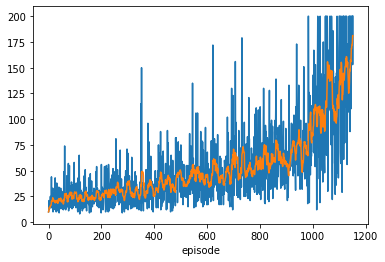

In [11]:
plt.plot(all_rewards)
plt.plot(avg_rewards)
plt.xlabel('episode')
plt.show()